# Imports

In [2]:
# @title Install GraphCast
# %pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip

In [3]:
# Basic imports
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Plotting and animations
import cartopy 
import cartopy.crs as ccrs
import math
import ipywidgets as widgets
import datetime
from IPython.display import HTML
from matplotlib import animation
from typing import Optional

# Model
from UNet import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Reshape

# Plotting functions

In [4]:
def select(
    data: xr.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xr.Dataset:
  data = data[variable]
  # if "batch" in data.dims:
  #   data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  # if level is not None and "level" in data.coords:
  #   data = data.sel(level=level)
  return data

def scale(
    data: xr.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xr.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)

  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()
  
  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
      reference_date = datetime.datetime(1970, 1, 1)
      if "time" in first_data.dims:
        td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
        td = reference_date + td
        figure.suptitle(f"{fig_title}, {td.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=16)
      else:
        figure.suptitle(fig_title, fontsize=16)
      for im, (plot_data, norm, cmap) in zip(images, data.values()):
        im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

# Data load and visualization

In [5]:
ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5



# ds = ds.sortby('latitude', ascending=True)
# ds = ds.assign_coords({"level": 1000})

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
# @title Choose data to plot

plot_example_variable = widgets.Dropdown(
    options=ds.data_vars.keys(),
    value="ws",
    description="Variable")
# plot_example_level = widgets.Dropdown(
#     options=ds.coords["level"].values,
#     value=1000,
#     description="Level")
plot_example_robust = widgets.Checkbox(value=True, description="Robust")
plot_example_max_steps = widgets.IntSlider(
    min=1, max=ds.dims["time"], value=6,
    description="Max steps")

widgets.VBox([
    plot_example_variable,
    # plot_example_level,
    plot_example_robust,
    plot_example_max_steps,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

C:\Users\23603526\AppData\Local\Temp\ipykernel_15680\2430431530.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  min=1, max=ds.dims["time"], value=6,


In [7]:
plot_size = 7
level = 1000

data = {
    " ": scale(select(ds, plot_example_variable.value, level, plot_example_max_steps.value),
              robust=plot_example_robust.value),
}

fig_title = plot_example_variable.value

plot_data(data, fig_title, plot_size, plot_example_robust.value)

# Data Prep

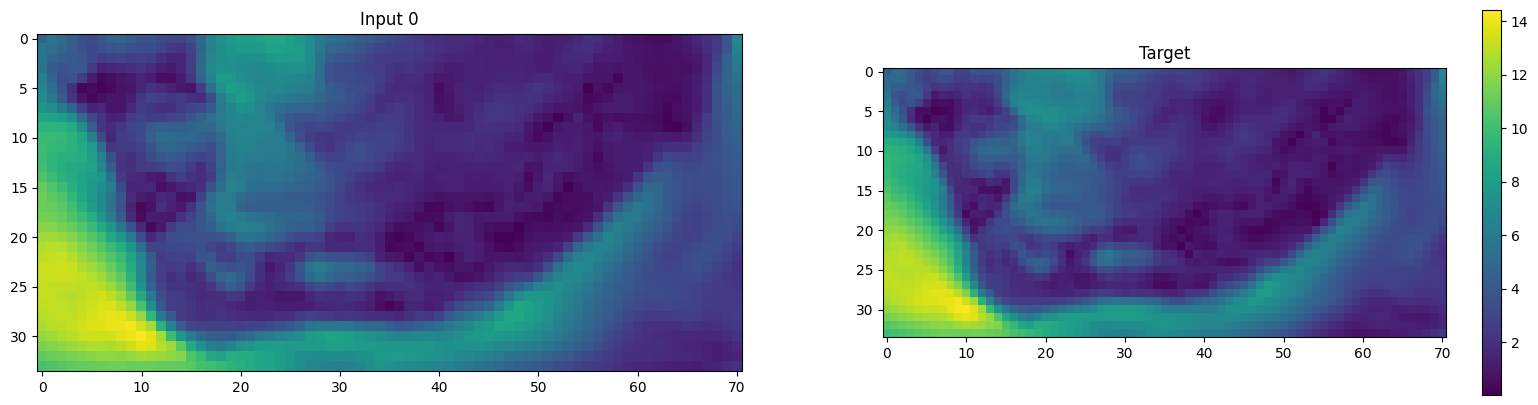

In [28]:
# Training and validation data
# Windowed input of images to predict the next image
# def normalization(ds):
#     min_val = ds.min()
#     max_val = ds.max()

#     normalized_data = (ds - min_val) / (max_val - min_val)

#     normalized_data = xr.where(normalized_data < 0, 0, normalized_data)
#     normalized_data = xr.where(normalized_data > 1, 1, normalized_data)

#     return normalized_data  

window_size = 1
variable = plot_example_variable.value
# plot_shape = [3, 10, 30]

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) # .reshape(-1, ds.longitude.size, ds.latitude.size, window_size)
y_ = np.array(y)

features = X_[0]
target = y_[0]

ax, fig = plt.subplots(1, window_size + 1, figsize=(20, 5))
for i in range(window_size):
    fig[i].imshow(features[i])
    fig[i].set_title(f'Input {i}')

fig[window_size].imshow(target)
fig[window_size].set_title('Target')
plt.colorbar(fig[window_size].imshow(target), ax=fig[window_size])
plt.show()


In [27]:
input_shape = X_.shape[1:]
split = round(X_.shape[0] * 0.9)

lon_shape = 70 # ds.longitude.size

X_ = X_[:,:,:, :70]
y_ = y_[:,:,:70]

max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

X_n = X_n.reshape(-1, ds.latitude.size, lon_shape, window_size)
y_n = y_n.reshape(-1, ds.latitude.size, lon_shape,  1)

f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
f_train.shape, t_train.shape, f_test.shape, t_test.shape

((7881, 34, 70, 3), (7881, 34, 70, 1), (876, 34, 70, 3), (876, 34, 70, 1))

In [10]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    # s2, p2 = encoder_block(p1, 128)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p1, 128) #Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    # d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(b1, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [11]:
input_shape

(1, 34, 71)

In [12]:

input_shape = f_train.shape[1:]
output_shape = t_train.shape[1:] 
# output_shape = tuple(math.ceil(x / 3) for x in output_shape)
kernel_size = (1, 3)
pool_size = (2,2)
model = build_unet(input_shape)
model.summary()  

print(model.predict(f_train[0:1]).shape)  



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34, 70, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 34, 70, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 34, 70, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 34, 70, 64)           0         ['batch_normalization[0]

In [13]:
batch_size = 128
epochs = 500
model.compile(optimizer='adam', loss='mse')

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

if False:
    history = model.fit(
        f_train, 
        t_train, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(f_test, t_test),
        callbacks=[early_stopping, model_checkpoint]
    )

else:
    model.load_weights('best_model_colab.h5')

28/28 [==============================] - 4s 129ms/step


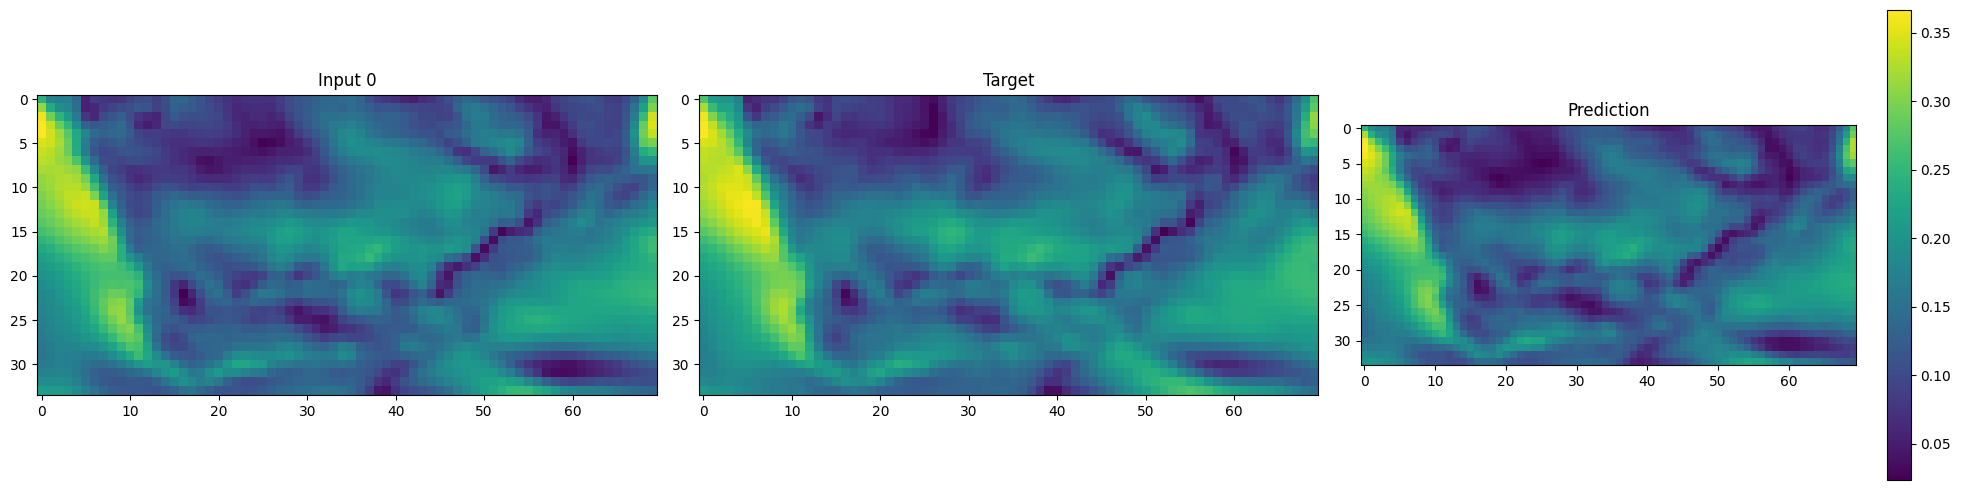

In [20]:
import matplotlib.pyplot as plt

pred = model.predict(f_test).reshape(-1, ds.latitude.size, lon_shape)

seed = 0 
features = f_test[seed].reshape(window_size, ds.latitude.size, lon_shape)
target = t_test[seed]

fig, ax = plt.subplots(1, window_size + 2, figsize=(20, 5))
for i in range(window_size):
    ax[i].imshow(features[i])
    ax[i].set_title(f'Input {i}')

ax[window_size].imshow(target)
ax[window_size].set_title('Target')

ax[window_size + 1].imshow(pred[0])
ax[window_size + 1].set_title('Prediction')

plt.colorbar(ax[window_size + 1].imshow(pred[0]), ax=ax[window_size + 1])

plt.tight_layout()
plt.show()



1/1 [==============================] - 0s 33ms/step


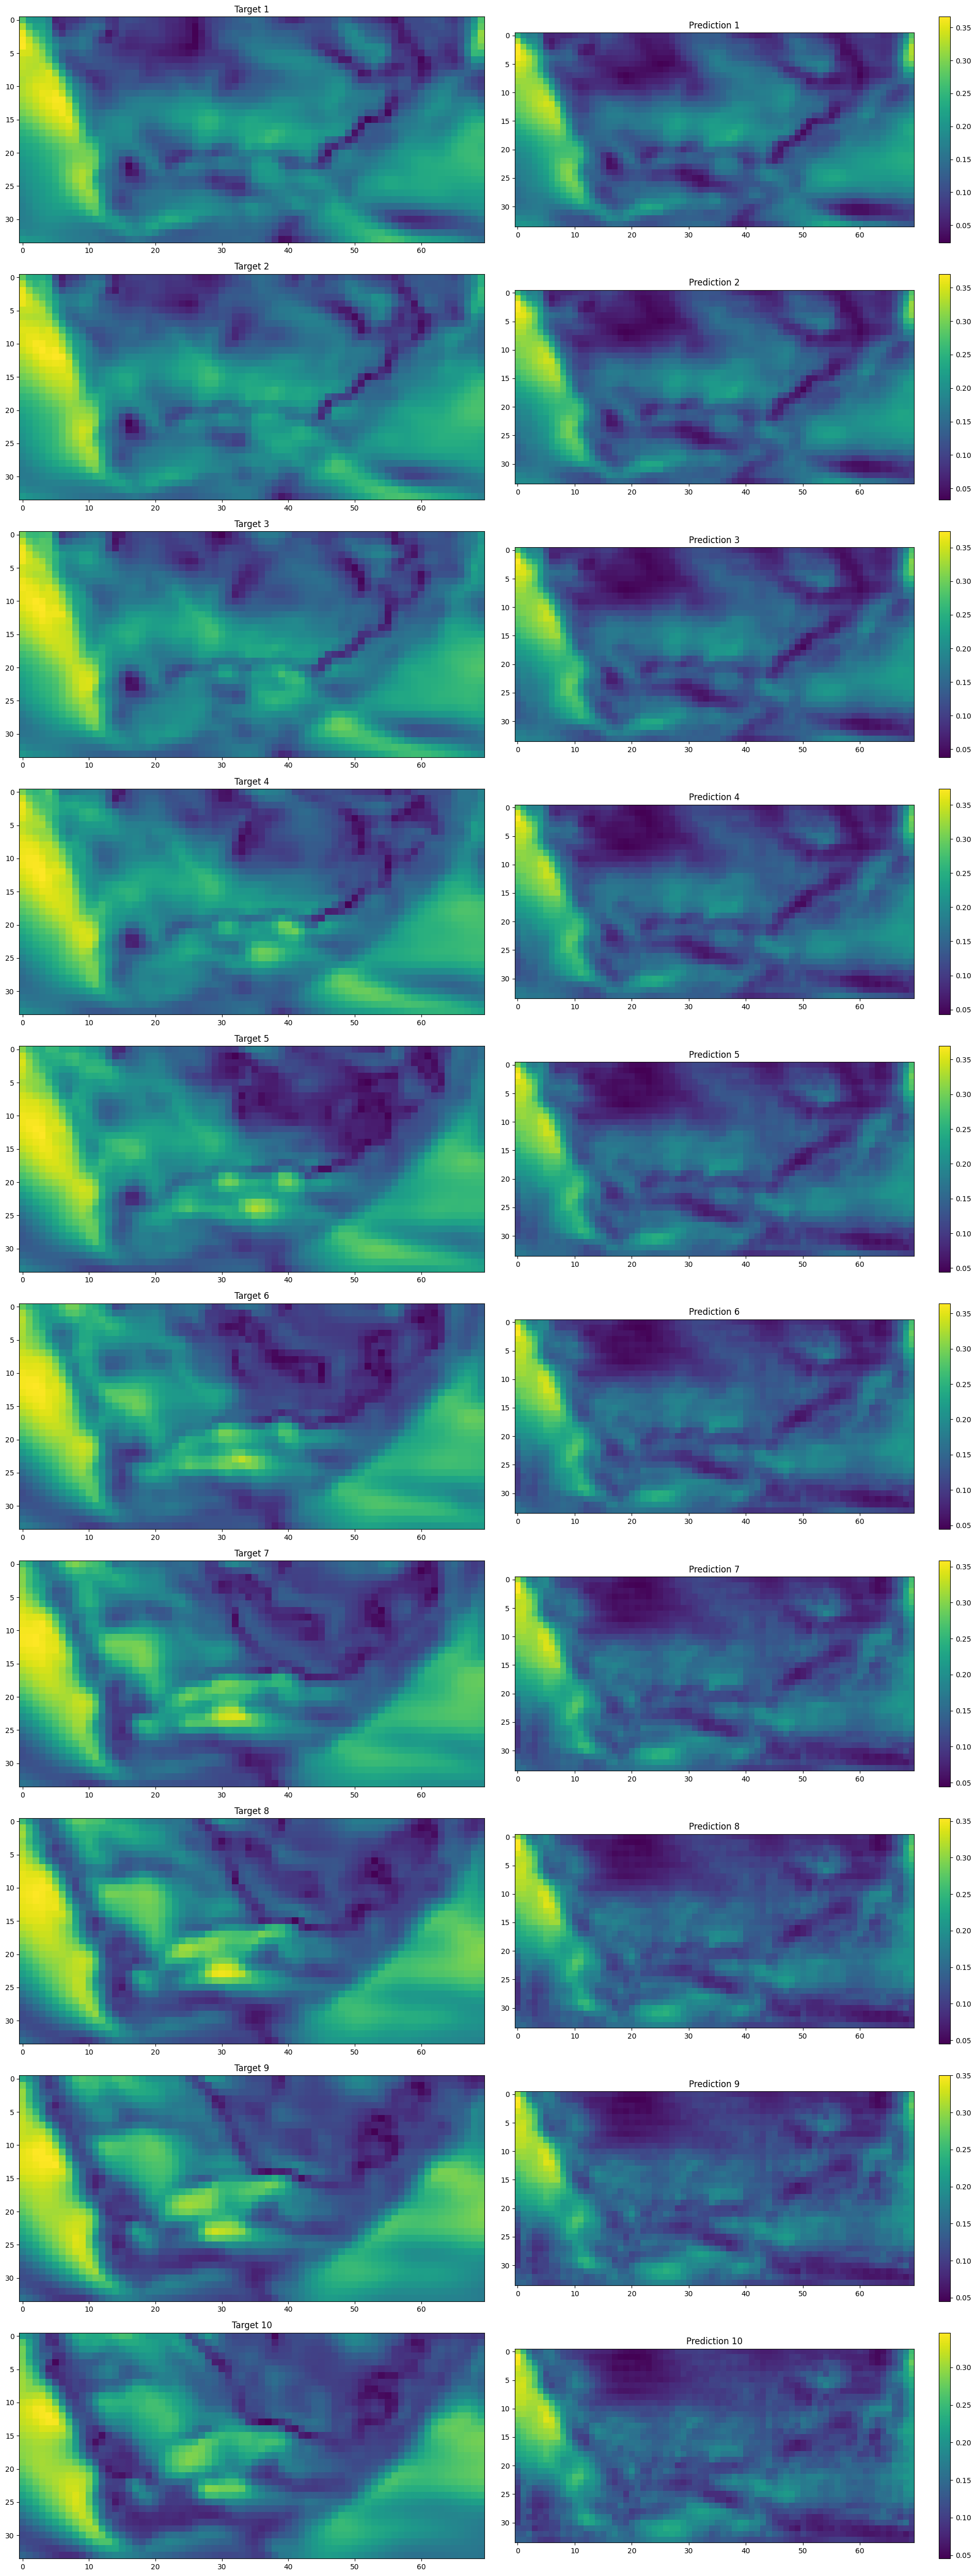

In [21]:
fig, ax = plt.subplots(10, 2, figsize=(20, 50))

pred_ = model.predict(f_test[0:1])  
pred = pred_.reshape(-1, ds.latitude.size, lon_shape)

for i in range(10):
    ax[i, 0].imshow(t_test[i])
    ax[i, 0].set_title(f'Target {i + 1}')


    im = ax[i, 1].imshow(pred[0])
    ax[i, 1].set_title(f'Prediction {i + 1}')

    plt.colorbar(im, ax=ax[i, 1])

    pred_ = model.predict(pred_)
    pred = pred_.reshape(-1, ds.latitude.size, lon_shape)

plt.tight_layout()
plt.show()



In [18]:
def rollout(current_state, steps=5):
    states = []
    for i in range(steps):
        pred_ = model.predict(current_state)
        pred = pred_.reshape(-1, ds.latitude.size, lon_shape)
        states.append(pred)
        current_state = concatenate(current_state[1:], pred_)
    return states

In [25]:
curret_state = f_test[0:1]
curret_state.shape

(1, 34, 70, 1)